# Create travel time grid with Pykonal 
more info in original publication : DOI: 10.1785/0220190318 <br>
https://www.researchgate.net/publication/341889419_PyKonal_A_Python_Package_for_Solving_the_Eikonal_Equation_in_Spherical_and_Cartesian_Coordinates_Using_the_Fast_Marching_Method <br>
Pykonal documentation : https://malcolmw.github.io/pykonal-docs/index.html

In [4]:
# standard data handling 
import numpy as np
import pandas as pd
import xarray as xr
# create progress bar 
from tqdm import tqdm
# plot
from matplotlib import pyplot as plt
# Convert UTM to other projection
import utm
# Ray tracing tool 
import pykonal
from pykonal.transformations import geo2sph


## 1) Load Velocity model 

Velocity model dimensions <br>
depth : in positive number of km (ie 5 km depth = 5, 200m above sea level = -0.2)<br>
sea level = earth radius 6371 km <br>
latitude : ° N <br>
longitude : in ° E


### 3D model from .CSV file 
Projection : spherical  

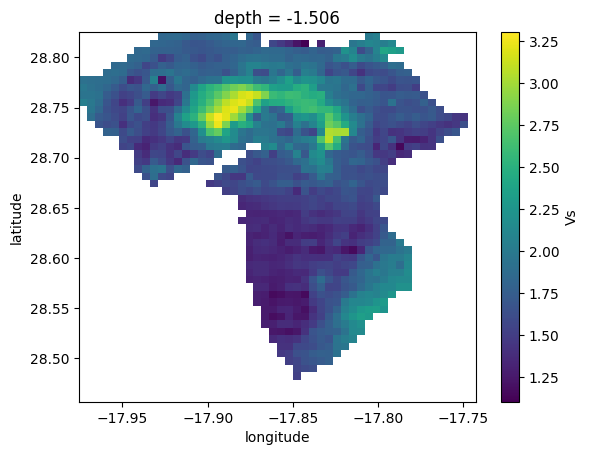

In [2]:
path_velocity_model = r'C:\Users\liliv\Desktop\La_palma\Velocity model\S\3D_Swave_velocity_model.csv'

df = pd.read_csv(path_velocity_model, sep = ',')

# Spherical projection 
df = df.rename(columns={'Z(m)': "depth", 'V(km/s)': 'Vs'})
lon_min = np.full(df.index.values.shape, min(df['X_UTM(m)'].values))
lat_min = np.full(df.index.values.shape, min(df['Y_UTM(m)'].values))
df['latitude'] = utm.to_latlon(lon_min, df['Y_UTM(m)'].values, 28,'R')[0]
df['longitude'] = utm.to_latlon( df['X_UTM(m)'].values, lat_min, 28,'R')[1]


'''# Cartesian projection
df = df.rename(columns={'Z(m)': "depth", 'V(km/s)': 'Vs', 'X_UTM(m)' : 'longitude', 'Y_UTM(m)' : 'latitude'})
df['longitude'] = df['longitude']/1000
df['latitude'] = df['latitude']/1000'''

# get epth in km 
df['depth'] = -df['depth']/1000

# Convert DataFrame to an xarray Dataset
ds = df.set_index(['latitude','longitude' ,'depth' ]).to_xarray()

# Extract the velocity as a DataArray
velocity_model = ds['Vs']

# If velocity model has no values above topography 
# extrude model upward to have all station within data domain 

fill_limit = 6  # Maximum number of times a NaN can be replaced
# Create a counter array to track the number of times a NaN is replace

test = velocity_model.values[::, ::, ::-1]
fill_count = np.zeros_like(test, dtype=int)

for depth_slice in range(1, test.shape[2]):
    old_slice = test[:, :, depth_slice - 1]
    new_slice = test[:, :, depth_slice]
    
    # Create a mask for NaN values that have been replaced less than twice
    mask = np.isnan(new_slice) & (fill_count[:, :, depth_slice] < fill_limit)
    
    # Replace values where the mask is True
    test[:, :, depth_slice][mask] = old_slice[mask]
    
    # Update the fill count for those replaced values
    fill_count[:, :, depth_slice:][mask] += 1

velocity_model.values = test[::, ::, ::-1]


velocity_model.isel(depth =5).plot()




### 3D from .buf and .hdr files (Work in progress)

In [ ]:
import numpy as np
import xarray as xr

def read_hdr(hdr_file):
    """Parse the NonLinLoc .hdr file."""
    metadata = {}
    with open(hdr_file, 'r') as f:
        print(f)
        for line in f:
            print(line)
            if line.startswith('GRID_SIZE'):
                metadata['grid_size'] = list(map(int, line.split()[1:]))
            elif line.startswith('GRID_SPACING'):
                metadata['grid_spacing'] = list(map(float, line.split()[1:]))
            elif line.startswith('GRID_ORIGIN'):
                metadata['grid_origin'] = list(map(float, line.split()[1:]))
            elif line.startswith('GRID_TYPE'):
                metadata['grid_type'] = line.split()[1].strip()
    return metadata

def read_buf(buf_file, grid_shape, dtype=np.float32):
    """Read the binary .buf file."""
    with open(buf_file, 'rb') as f:
        data = np.fromfile(f, dtype=dtype)
    return data.reshape(grid_shape)

def integrate_nlloc(buf_file, hdr_file):
    """Integrate .buf and .hdr files into an xarray Dataset."""
    # Parse the .hdr file
    metadata = read_hdr(hdr_file)
    print(metadata)
    
    # Extract metadata

    grid_size = metadata['grid_size']
    grid_spacing = metadata['grid_spacing']
    grid_origin = metadata['grid_origin']
    grid_type = metadata['grid_type']
    
    # Read the .buf file
    data = read_buf(buf_file, grid_size)
    
    # Create coordinate arrays
    x = grid_origin[0] + np.arange(grid_size[0]) * grid_spacing[0]
    y = grid_origin[1] + np.arange(grid_size[1]) * grid_spacing[1]
    z = grid_origin[2] + np.arange(grid_size[2]) * grid_spacing[2]
    
    # Create xarray DataArray
    da = xr.DataArray(
        data,
        coords={'x': x, 'y': y, 'z': z},
        dims=['x', 'y', 'z'],
        attrs={'grid_type': grid_type}
    )
    
    # Convert to Dataset
    ds = da.to_dataset(name='nlloc_grid')
    return ds

# Example usage
buf_file = r"C:\Users\liliv\Desktop\La_palma\Velocity model\P\layer3d.P.mod.buf"
hdr_file = r"C:\Users\liliv\Desktop\La_palma\Velocity model\P\layer3d.P.mod.hdr"
dataset = integrate_nlloc(buf_file, hdr_file)




<_io.TextIOWrapper name='C:\\Users\\liliv\\Desktop\\La_palma\\Velocity model\\P\\layer3d.P.mod.hdr' mode='r' encoding='UTF-8'>
{}


KeyError: 'grid_size'

### 1D model from .CSV file 
projection : spherical

In [ ]:
63.85923,-22.33035
63.91461,-22.20656


In [5]:
FILEPATH_VELOCITY = r"C:\Users\liliv\Desktop\Fagradalfjall\Tremor_loc\Velocity model\SIL.csv"
depths = np.linspace(-2, 5, 100)
latitudes = np.linspace(63.81810, 64.03551,100)
longitudes = np.linspace(-22.62691, -21.94679, 100)

phase = 'Vs'

smoothing_window = 4

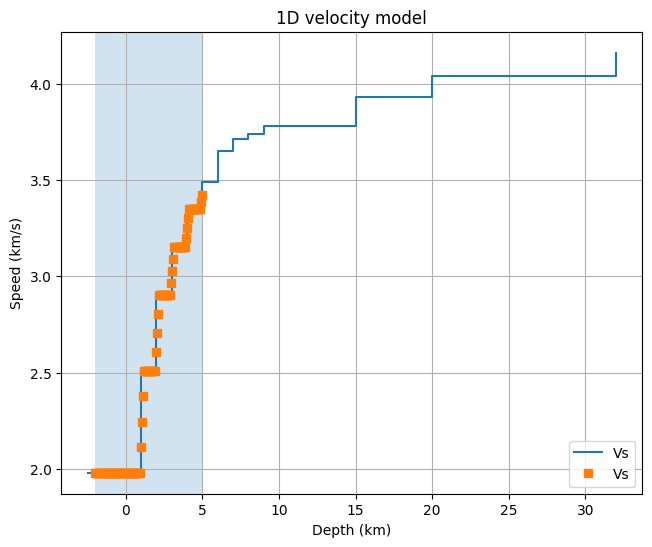

In [6]:
velocity_layers = pd.read_csv(
    FILEPATH_VELOCITY,
    usecols=[0, 3],
    names=["depth", 'Vs'],
    skiprows=1,
    index_col="depth",
    )


'''# units are in km 
velocity_layers *= 1e-3
velocity_layers.index *= 1e-3'''
# quick visualisation
velocity_layers.T

velocity_layers_interp = velocity_layers.reindex(depths, method="ffill")
padded_data = np.pad(velocity_layers_interp[phase].values, pad_width=smoothing_window//2, mode='edge')

# smoothing on model
if smoothing_window %2 != 0:
    velocity_layers_interp[phase] = np.convolve(padded_data, np.ones(smoothing_window)/smoothing_window, mode = 'valid')[:]
if smoothing_window %2 == 0:
    velocity_layers_interp[phase] = np.convolve(padded_data, np.ones(smoothing_window)/smoothing_window, mode = 'valid')[:-1]
velocity_layers.plot(drawstyle="steps-post")
velocity_layers_interp.sort_values("depth").plot(
    drawstyle="steps-post",
    xlabel="Depth (km)",
    ylabel="Speed (km/s)",
    title="1D velocity model",
    ax=plt.gca(),
    grid=True,
    figsize=(7.5, 6),
    marker="s",
    ls=""
)
plt.axvspan(depths.min(), depths.max(), alpha=0.2) # Labels and legends
#plt.legend(["P", "S", "P interpolated", "S interpolated", "Domain"])
plt.show()
#### La Palma

velocities = velocity_layers_interp.stack().to_xarray()
velocities = velocities.rename({"level_1": "phase"})
velocities = velocities.sel(phase = phase)
velocity_model = velocities.expand_dims(latitude=latitudes, longitude=longitudes)

### Homogeneous velocity model
projection : spherical

In [10]:
C = 1 # km/s

depths = np.linspace(-2, 5, 100)
latitudes = np.linspace(63.85923, 63.91461,100)
longitudes = np.linspace(-22.33035, -22.20656, 100)

depths = np.linspace(-2, 5, 100)
latitudes = np.linspace(63.81810, 64.03551,100)
longitudes = np.linspace(-22.62691, -21.94679, 100)

In [11]:
# Create a 3D array filled with the value C
data = np.full((len(depths), len(latitudes), len(longitudes)), C)

# Create the DataArray
velocity_model = xr.DataArray(
    data,
    coords={
        "depth": depths,
        "latitude": latitudes,
        "longitude": longitudes
    },
    dims=["depth", "latitude", "longitude"],
    name="velocity"
)

## 2) Resize

### extrude to extand grid if one of the stations is not inside
Take the last slide in the velocity model and extrude it to the new coordinate 

### Longitude to the West 

In [9]:
################################################################
######################### Longitude ############################
################################################################

## INPUT ###
new_lon_max = -18 # 25
### EXTRACT DATA ###
lon_axis = velocity_model.coords['longitude'].values
lon_delta = np.mean(np.abs(lon_axis[1:]-lon_axis[:-1]))
last_slice = velocity_model.sel(longitude=min(lon_axis)).values
last_slice = np.expand_dims(last_slice, axis = 1)
### CREATE NEW AXIS ###
new_lon_axis = np.append(new_lon_max,lon_axis )
new_values = np.append(last_slice,velocity_model.values, axis = 1)
velocity_model=xr.DataArray(data=new_values,
                            dims=['latitude', 'longitude', 'depth'], 
                            coords=[velocity_model.coords['latitude'].values, new_lon_axis, velocity_model.coords['depth'].values])
new_lon = np.linspace(velocity_model.coords['longitude'][0], velocity_model.coords['longitude'][-1], int(np.abs((velocity_model.coords['longitude'][0]-velocity_model.coords['longitude'][-1])/lon_delta)))
velocity_model = velocity_model.interp(longitude = new_lon, method='linear')
print(velocity_model.shape)

(100, 574, 100)


### Longitude to the East 

In [42]:
################################################################
######################### Longitude ############################
################################################################

## INPUT ###
new_lon_min = -17.50 # -18 # 25
### EXTRACT DATA ###
lon_axis = velocity_model.coords['longitude'].values
lon_delta = np.mean(np.abs(lon_axis[1:]-lon_axis[:-1]))
last_slice = velocity_model.sel(longitude=max(lon_axis)).values
last_slice = np.expand_dims(last_slice, axis = 1)
### CREATE NEW AXIS ###
new_lon_axis = np.append(lon_axis, new_lon_min )
new_values = np.append(velocity_model.values,last_slice, axis = 1)
velocity_model=xr.DataArray(data=new_values,
                            dims=['latitude', 'longitude', 'depth'], 
                            coords=[velocity_model.coords['latitude'].values, new_lon_axis, velocity_model.coords['depth'].values])
new_lon = np.linspace(velocity_model.coords['longitude'][0], velocity_model.coords['longitude'][-1], int(np.abs((velocity_model.coords['longitude'][0]-velocity_model.coords['longitude'][-1])/lon_delta)))
velocity_model = velocity_model.interp(longitude = new_lon, method='linear')
print(velocity_model.shape)

(50, 103, 47)


### Depth Top

In [298]:
################################################################
########################### Depth ##############################
################################################################

## INPUT ###
new_depth_min = -3
### EXTRACT DATA ###
depth_axis = velocity_model.coords['depth'].values
depth_delta = np.median(np.abs(depth_axis[1:]-depth_axis[:-1]))
last_slice = velocity_model.sel(depth=min(depth_axis)).values
last_slice = np.expand_dims(last_slice, axis = 2)
### CREATE NEW AXIS ###
new_dep_axis = np.append(new_depth_min, depth_axis )
new_values = np.append(last_slice, velocity_model.values, axis = 2)
velocity_model=xr.DataArray(data=new_values,
                            dims=['latitude', 'longitude', 'depth'], 
                            coords=[velocity_model.coords['latitude'].values, velocity_model.coords['longitude'], new_dep_axis])
new_depth = np.linspace(velocity_model.coords['depth'][0], velocity_model.coords['depth'][-1], int(np.abs((velocity_model.coords['depth'][0]-velocity_model.coords['depth'][-1])/depth_delta)))
velocity_model = velocity_model.interp(depth = new_depth, method='linear')

### Depth bottom

In [7]:
################################################################
########################### Depth ##############################
################################################################

## INPUT ###
new_depth_max = -10000
### EXTRACT DATA ###
depth_axis = velocity_model.coords['depth'].values
depth_delta = np.median(np.abs(depth_axis[1:]-depth_axis[:-1]))
last_slice = velocity_model.sel(depth=min(depth_axis)).values
last_slice = np.expand_dims(last_slice, axis = 2)
### CREATE NEW AXIS ###
new_dep_axis = np.append(new_depth_max, depth_axis )
new_values = np.append(velocity_model.values,last_slice, axis = 2)
velocity_model=xr.DataArray(data=new_values,
                            dims=['latitude', 'longitude', 'depth'], 
                            coords=[velocity_model.coords['latitude'].values, velocity_model.coords['longitude'], new_dep_axis])
new_depth = np.linspace(velocity_model.coords['depth'][0], velocity_model.coords['depth'][-1], int(np.abs((velocity_model.coords['depth'][0]-velocity_model.coords['depth'][-1])/depth_delta)))
velocity_model = velocity_model.interp(depth = new_depth, method='linear')

ValueError: coords is not dict-like, but it has 3 items, which does not match the 4 dimensions of the data

## 3) Resample Model 

Insure that the model has homogeneous spacing along dimension 

In [12]:
### resample velocity grid ###
n_lat_sample = 100 # number of lat sample for new grid 
n_lon_sample = 101 # number of lon sample for new grid 
n_dep_sample = 102 # number of sample for new depth grid 

lat_ratio = velocity_model.coords['latitude'].shape[0]/n_lat_sample
lon_ratio = velocity_model.coords['longitude'].shape[0]/n_lon_sample
dep_ratio = velocity_model.coords['depth'].shape[0]/n_dep_sample

### CORE ###
new_lat = np.linspace(velocity_model.coords['latitude'][0], velocity_model.coords['latitude'][-1], n_lat_sample)
new_lon = np.linspace(velocity_model.coords['longitude'][0], velocity_model.coords['longitude'][-1], n_lon_sample)
new_dep = np.linspace(velocity_model.coords['depth'][0], velocity_model.coords['depth'][-1], n_dep_sample)

velocity_model = velocity_model.interp(latitude = new_lat, longitude = new_lon, depth = new_dep, method='linear')


In [13]:
# Orientation of the grid 
# The reference point (corner top left at the bottom of the grid) is a max or a min value of the axis? 
# Allows to give correct orientation of the grid and avoid flipping during computation.


ref_lon = 'min'
ref_lat = 'max'
ref_depth = 'max'

# Ensure coordinates are in descending order
if velocity_model.latitude.values[0] > velocity_model.latitude.values[-1] and ref_lat == 'min' :
    velocity_model = velocity_model.sortby("latitude", ascending=True)
if velocity_model.latitude.values[0] < velocity_model.latitude.values[-1] and ref_lat == 'max' :
    velocity_model = velocity_model.sortby("latitude", ascending=False)

if velocity_model.longitude.values[0] > velocity_model.longitude.values[-1] and ref_lon == 'min' :
    velocity_model = velocity_model.sortby("longitude", ascending=True)
if velocity_model.longitude.values[0] < velocity_model.longitude.values[-1] and ref_lon == 'max' :
    velocity_model = velocity_model.sortby("longitude", ascending=False)

if velocity_model.depth.values[0] > velocity_model.depth.values[-1] and ref_depth == 'min' :
    velocity_model = velocity_model.sortby("depth", ascending=True)
if velocity_model.depth.values[0] < velocity_model.depth.values[-1] and ref_depth == 'max' :
    velocity_model = velocity_model.sortby("depth", ascending=False)


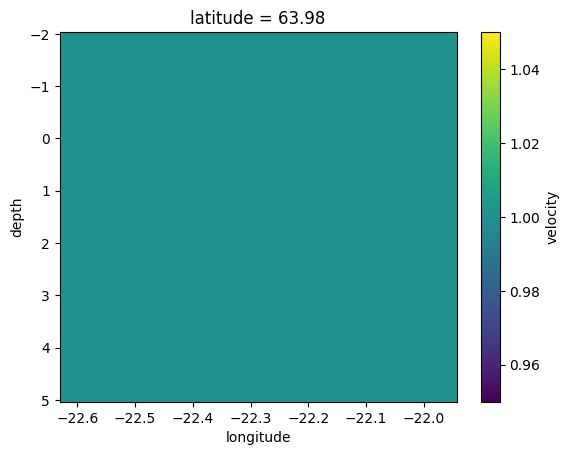

In [14]:
velocity_model.isel(latitude =25).plot(x = 'longitude')
plt.gca().invert_yaxis()

## 4) Load station information

In [18]:
### path to station info ###
station_info_path = r'C:\Users\liliv\Desktop\Fagradalfjall\Tremor_loc\Velocity model\station_fagra.csv'
station_info = pd.read_csv(station_info_path, sep = ',', index_col =0)
print(station_info.tail())
STATION_ENTRIES = ["lat", "lon", "alt"] # order = lat, lon, dep



            lat        lon  altitude     alt  angle  dip  distance_along_fiber
Name                                                                          
odf   63.946900 -22.119000        60 -0.0060      0   90                     0
rah   63.852855 -22.567946        51 -0.0051      0   90                     0
sgi   63.863371 -22.329210       177 -0.0177      0   90                     0
vatn  63.872700 -22.374300        80 -0.0080      0   90                     0
vog   63.969670 -22.392850         7 -0.0007      0   90                     0


In [23]:
lon_ref = -68.0073626
lat_ref = -22.3276872
conversion_lat = 111.32
conversion_lon = 111.32*np.cos(lat_ref)
station_info['longitude'] = -(station_info['longitude'] - lon_ref)*conversion_lon
station_info['latitude'] = -(station_info['latitude'] - lat_ref)*conversion_lat
print(station_info.tail())

KeyError: 'longitude'

## 5) Calculate travel time SPHERICAL 
!!! Velocity model with SPHERICAL coordinates !!!

### Issues and trouble shooting 


1) the model run but the location of the station (min travel time) is not correct. <br>In my case I was working on La Palma and my station was on the other side of the island (It should be in the north and ends up in the south, i.e. latitude inverted). <br>
Solution : The velocity grid given to the model is in the wrong direction. Pykonal expect dimensions to increase from deep to shallow, north to south and east to west. I was feeding a map oriented south to north (increasing latitude). <br>
Fix : when extracting velocity values flip matrix direction by : <br>   solver.velocity.values =velocities.values[:,::-1,:]<br>
Don't forget that it is [depth, lat ,lon] at this stage so I invert the second axis to invert latitude in my case. Once computations are done flip the matrix back to match the original axis directions : <br>  travel_times.values  = tt [:,::-1,:]

2) if all values are np.inf in travel time grid <br>it could be caused by the source being defined outside of the model's grid (verify of source parameters, the classic is depth express in meters when pykonals takes km and / or grid dimensions)

3. To verify that all parameters are set correctly, one can run a grid with velocities of 1km/s with a source at the grid origin: <br>
solver.src_loc = reference_point <br>
The time in second at the edges should equal the dimensions in km of the grid 

### Model dimensions and reference points
==> reference point = lowest, northest, eastest point of the model. <br>
==> node interval = distance between adjacent  nodes for: depth from sea level (km), latitude (radians), longitude (radians) [sperical model]

In [19]:
### CREATE MODEL REFERENCE ### 

# ==>   reference_point = lowest, northest, eastest point of the model.
# ==>   depth, lat, lon =  geo2sph((lat, lon, depth)).

latitudes = velocity_model.coords['latitude'].values
longitudes = velocity_model.coords['longitude'].values
depths = velocity_model.coords['depth'].values
reference_point = geo2sph((latitudes.max(), longitudes.min(), depths.max()))
print(reference_point)

# ==> node_interval = distance between adjacent  nodes for: depth (m), latitude (radians), longitude (radians).
# ==> The units for nodal distance are m,rad,rad for spherical model but becoms m, m, m for carteian model
# ==> !!! lat and lon in radians because model in spherical coordinates (mandatory for PointSourceSolver) otherwise can create a cartesian model, then units are not the same.

node_intervals = (
    np.abs(depths[1] - depths[0]),
    np.deg2rad(np.abs(latitudes[1] - latitudes[0])),
    np.deg2rad(np.abs(longitudes[1] - longitudes[0])),
)
print(node_intervals)

[ 6.36600000e+03  4.53165839e-01 -3.94914079e-01]
(0.06930693069306848, 3.832848814921764e-05, 0.00011870333308666851)


### Computation

In [20]:
# transpose velocity model to go from lat lon depth to depth lat lon
velocities = velocity_model.transpose( 'depth','latitude', 'longitude').copy()
# container to keep travel time grids 
ttime_ds = xr.Dataset( coords=velocity_model.coords)

for Station_Name in tqdm(station_info.index):

    ### Create and run model ###
    solver = pykonal.solver.PointSourceSolver(coord_sys="spherical")
    solver.velocity.min_coords = reference_point
    solver.velocity.node_intervals = node_intervals
    solver.velocity.npts = velocities.values.shape
    solver.velocity.values = velocities.values[::,::,::]

    # Initialize the source location with a random location within the
    # computational grid.
    # Source
    src_loc = station_info.loc[Station_Name][STATION_ENTRIES].values
    #src_loc[2] = -src_loc[2]/1000
    solver.src_loc = np.array(geo2sph(src_loc).squeeze()) # 

    # Compute traveltimes.
    solver.solve()

    tt = solver.tt.values

    travel_times = velocities.copy()
    travel_times.values  = tt [::,::,::]
    travel_times = travel_times.transpose('latitude', 'longitude', 'depth')

    values = travel_times.values[::,::,::]
    values = np.where(np.abs(values) > 50, np.nan, values)
    values[np.isinf(values)] = np.nan
    data_array = xr.DataArray(values, dims = travel_times.dims, coords=travel_times.coords)
    ttime_ds[str(Station_Name)] = data_array

100%|██████████| 22/22 [02:08<00:00,  5.82s/it]


### plot travel time grid to visualy inspect data and verify that it make sense 

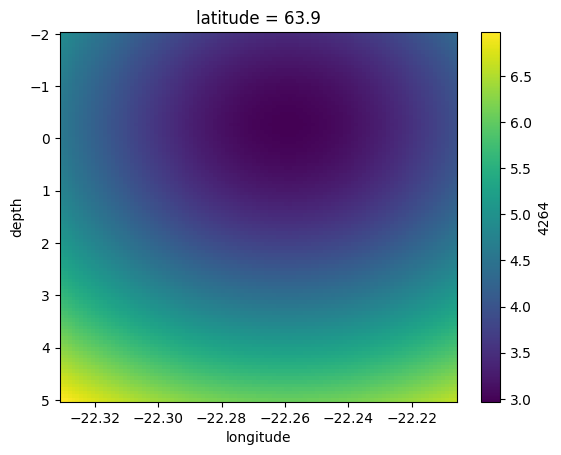

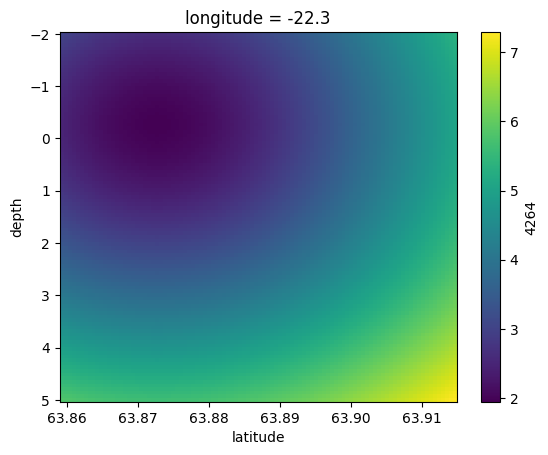

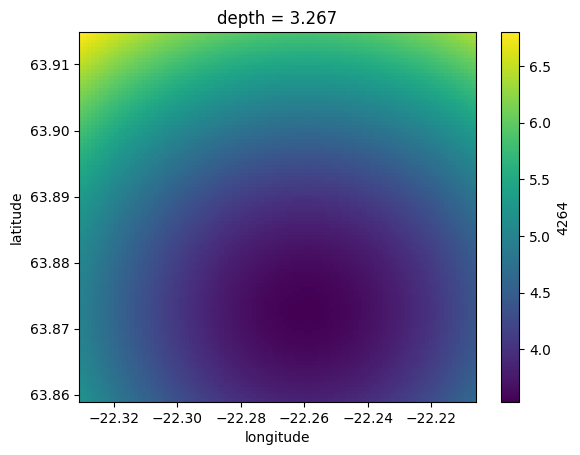

In [10]:
# change slice index in isel() to moove them in the grid 
station = '4264'

ttime_ds[station].isel(latitude = 27).plot(x = 'longitude')
plt.gca().invert_yaxis()
plt.show()
ttime_ds[station].isel(longitude = 25).plot(x = 'latitude')
plt.gca().invert_yaxis()
plt.show()
ttime_ds[station].isel(depth = 25).plot(x = 'longitude')

## 5) Calculate travel time CARTESIAN 
!!! Velocity model with CARTESIAN coordinates !!! <br>
Cells from above gives spherical (lat lon) coordiantes 

### Model dimentions and reference points
==> reference_point = lowest, northest, eastest point of the model. <br>
==> node_interval = distance between adjacent  nodes for: z (depth) (km), y (latitude) (km), x (longitude) (km) [sperical model]

In [32]:
### CREATE MODEL REFERENCE ### 
# ==>   reference_point = lowest, northest, eastest point of the model.
# ==>   depth, lat, lon =  geo2sph((lat, lon, depth)).

latitudes = velocity_model.coords['latitude'].values
longitudes = velocity_model.coords['longitude'].values
depths = velocity_model.coords['depth'].values
reference_point = (0,0,0)#(0, latitudes.max(), longitudes.min())#depths.max()
print(reference_point)

# ==> node_interval = distance between adjacent  nodes for: depth (m), latitude (radians), longitude (radians).
# ==> The units for nodal distance are m,rad,rad for spherical model but becoms m, m, m for carteian model
# ==> !!! lat and lon in radians because model in spherical coordinates (mandatory for PointSourceSolver) otherwise can create a cartesian model, then units are not the same.
node_intervals = (
    np.abs(depths[1] - depths[0]),
    np.abs(latitudes[1] - latitudes[0]),
    np.abs(longitudes[1] - longitudes[0]),
)
print(node_intervals)


(0, 0, 0)
(0.0015841584158415856, 0.0016161616161616266, 0.0016)


### Computation

In [36]:
# transpose velocity model to go from lat lon depth to depth lat lon
velocities = velocity_model.transpose( 'depth','latitude', 'longitude')
# container to keep travel time grids 
ttime_ds = xr.Dataset( coords=velocity_model.coords)
count = 0
for Station_Name in tqdm(station_info.index):
    if count == 0:

        ### Create and run model ###
        solver = pykonal.solver.PointSourceSolver(coord_sys="cartesian")
        solver.velocity.min_coords = 0, 0, 0
        solver.velocity.node_intervals = node_intervals
        solver.velocity.npts = velocities.values.shape
        solver.velocity.values = velocities.values[::,::,::]

        # Initialize the source location with a random location within the
        # computational grid.
        # Source
        '''lat_source, lon_source, dep_source = station_info.loc[Station_Name][STATION_ENTRIES].values
        UTM_coord =  utm.from_latlon(lat_source, lon_source)
        lat_source, lon_source = (latitudes.max() - UTM_coord [1]/1000),  (UTM_coord [0]/1000- longitudes.min())
        src_loc = np.array([-(-5+dep_source), lat_source, lon_source])'''
        src_loc = station_info.loc[Station_Name][STATION_ENTRIES].values
        src_loc = np.array([-src_loc[2]+0.160, src_loc[0], src_loc[1]])
        solver.src_loc = src_loc # 

        # Compute traveltimes.
        solver.solve()

        tt = solver.tt.values
        tt[np.isinf(tt)] = np.nan

        travel_times = velocities.copy()
        travel_times.values  = tt [::,::,::]
        data_array = travel_times.transpose('latitude', 'longitude', 'depth')
        '''data_array = data_array.sortby("depth", ascending=True)
        data_array = data_array.sortby("latitude", ascending=True)
        data_array = data_array.sortby("longitude", ascending=True)
        data_array = data_array.interpolate_na(dim= 'depth', method="linear")
        data_array = data_array.interpolate_na(dim= 'latitude', method="linear")
        data_array = data_array.interpolate_na(dim= 'longitude', method="linear")'''
        # Ensure coordinates are in descending order
        ttime_ds[str(Station_Name)] = data_array
        count = 1
    else: 
        count = 0

100%|██████████| 771/771 [22:40<00:00,  1.76s/it]


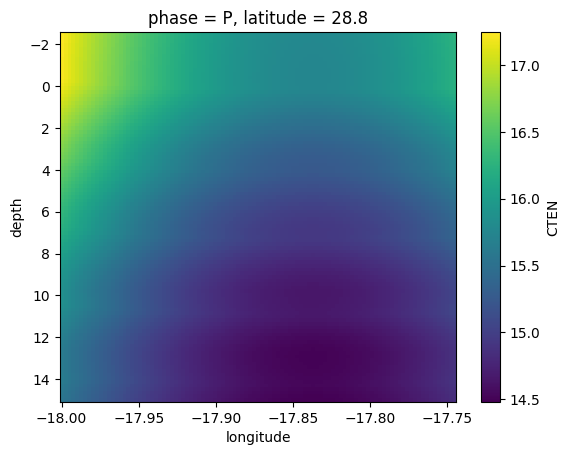

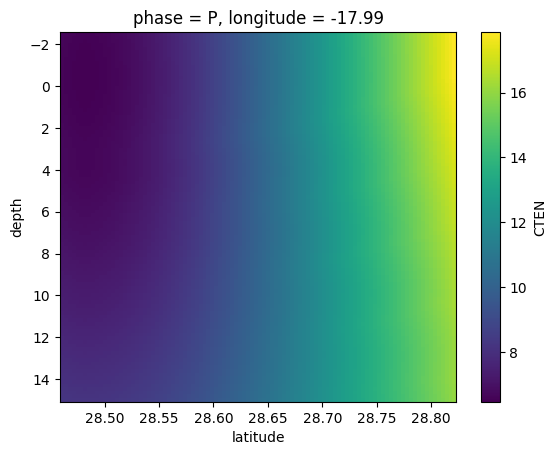

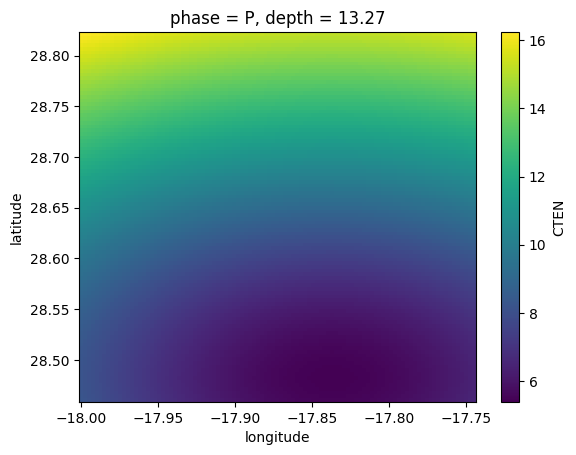

In [ ]:
# change slice index in isel() to moove them in the grid 
station = 'CTEN'

ttime_ds[station].isel(latitude = 5).plot(x = 'longitude')
plt.gca().invert_yaxis()
plt.show()
ttime_ds[station].isel(longitude = 5).plot(x = 'latitude')
plt.gca().invert_yaxis()
plt.show()
ttime_ds[station].isel(depth = 10).plot(x = 'longitude')

## 6) Save ttime grids in h5 format 

In [47]:
### resample travel time grid before saving if needed ###
n_lat_sample = 100 # number of lat sample for new grid 
n_lon_sample = 101 # number of lon sample for new grid 
n_dep_sample = 102 # number of sample for new depth grid 

lat_ratio = ttime_ds.coords['latitude'].shape[0]/n_lat_sample
lon_ratio = ttime_ds.coords['longitude'].shape[0]/n_lon_sample
dep_ratio = ttime_ds.coords['depth'].shape[0]/n_dep_sample

### CORE ###
new_lat = np.linspace(ttime_ds.coords['latitude'][0], ttime_ds.coords['latitude'][-1], n_lat_sample)
new_lon = np.linspace(ttime_ds.coords['longitude'][0], ttime_ds.coords['longitude'][-1], n_lon_sample)
new_dep = np.linspace(ttime_ds.coords['depth'][0], ttime_ds.coords['depth'][-1], n_dep_sample)

ttime_ds = ttime_ds.interp(latitude = new_lat, longitude = new_lon, depth = new_dep, method='linear')

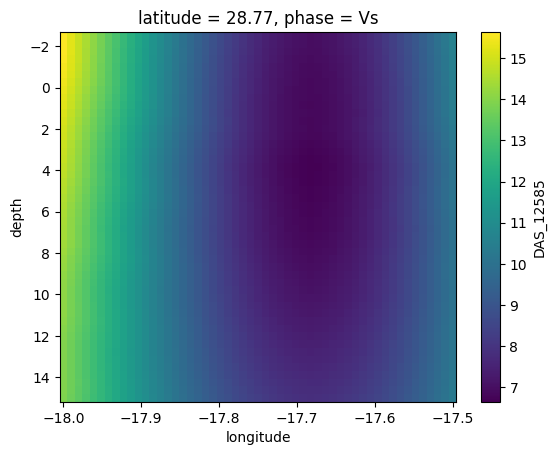

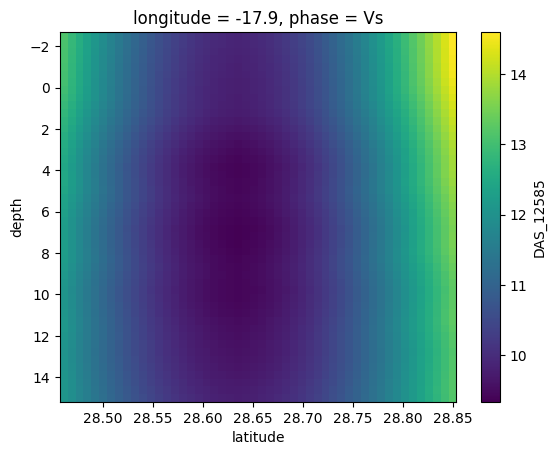

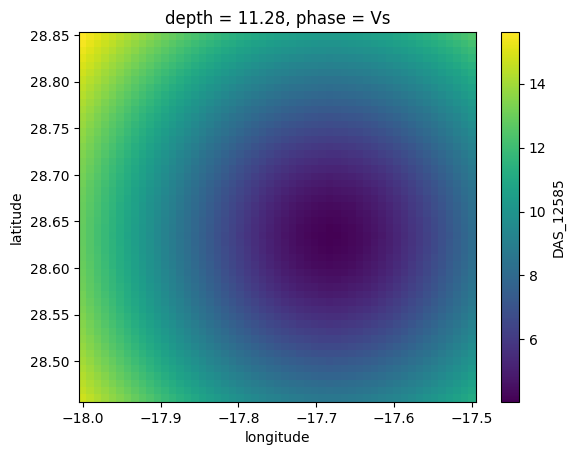

In [29]:
# change slice index in isel() to moove them in the grid 
station = 'DAS_12585'

ttime_ds[station].isel(latitude = 10).plot(x = 'longitude')
plt.gca().invert_yaxis()
plt.show()
ttime_ds[station].isel(longitude = 10).plot(x = 'latitude')
plt.gca().invert_yaxis()
plt.show()
ttime_ds[station].isel(depth = 10).plot(x = 'longitude')

In [48]:
ttime_ds

<xarray.Dataset>
Dimensions:    (latitude: 100, longitude: 101, depth: 102)
Coordinates:
  * latitude   (latitude) float64 63.86 63.86 63.86 63.86 ... 63.91 63.91 63.91
  * longitude  (longitude) float64 -22.33 -22.33 -22.33 ... -22.21 -22.21 -22.21
  * depth      (depth) float64 -2.0 -1.931 -1.861 -1.792 ... 4.861 4.931 5.0
Data variables: (12/22)
    faf        (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    ash        (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    iss        (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    lag        (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    lat        (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    lsf        (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    ...         ...
    muka       (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    odf        (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    rah        (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    sgi        (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    vatn       (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    vog        (latitude, longitude, depth) float64 nan nan nan ... nan nan nan

In [49]:
saving_folder= r'C:\Users\liliv\Desktop\Fagradalfjall\Tremor_loc\Velocity model\ttime grids'
file_name = 'stations_AF'

ttime_ds.to_netcdf(saving_folder+'\\'+file_name+'.h5')

In [46]:
ttime_ds = resampled.copy()

In [34]:
import numpy as np

new_depths = np.linspace(-2, 5, 100)
new_lats = np.linspace(63.85923, 63.91461,100)
new_lons = np.linspace(-22.33035, -22.20656, 100)
# Assume your original DataArray is called `tt_grid`
subset = ttime_ds.sel(
    latitude=slice(new_lats.max(), new_lats.min()),
    longitude=slice(new_lons.min(), new_lons.max()),
)
print(subset)
resampled = subset.interp(
    latitude=new_lats,
    longitude=new_lons,
    depth=new_depths,
    method="linear"  # or "nearest", "cubic" if supported
)



<xarray.Dataset>
Dimensions:    (latitude: 127, longitude: 18, depth: 102)
Coordinates:
  * latitude   (latitude) float64 63.91 63.91 63.91 63.91 ... 63.86 63.86 63.86
  * longitude  (longitude) float64 -22.33 -22.32 -22.31 ... -22.23 -22.22 -22.21
  * depth      (depth) float64 5.0 4.931 4.861 4.792 ... -1.861 -1.931 -2.0
Data variables: (12/22)
    faf        (latitude, longitude, depth) float64 7.446 7.399 ... 5.535 5.558
    ash        (latitude, longitude, depth) float64 13.3 13.28 ... 14.8 14.81
    iss        (latitude, longitude, depth) float64 7.686 7.641 ... 4.847 4.875
    lag        (latitude, longitude, depth) float64 9.298 9.261 ... 14.46 14.47
    lat        (latitude, longitude, depth) float64 10.49 10.46 ... 2.286 2.347
    lsf        (latitude, longitude, depth) float64 5.542 5.479 ... 10.58 10.6
    ...         ...
    muka       (latitude, longitude, depth) float64 6.279 6.223 ... 5.744 5.767
    odf        (latitude, longitude, depth) float64 11.83 11.8 ... 10.87 1

In [35]:
resampled

<xarray.Dataset>
Dimensions:    (latitude: 100, longitude: 100, depth: 100)
Coordinates:
  * latitude   (latitude) float64 63.86 63.86 63.86 63.86 ... 63.91 63.91 63.91
  * longitude  (longitude) float64 -22.33 -22.33 -22.33 ... -22.21 -22.21 -22.21
  * depth      (depth) float64 -2.0 -1.929 -1.859 -1.788 ... 4.859 4.929 5.0
Data variables: (12/22)
    faf        (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    ash        (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    iss        (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    lag        (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    lat        (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    lsf        (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    ...         ...
    muka       (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    odf        (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    rah        (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    sgi        (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    vatn       (latitude, longitude, depth) float64 nan nan nan ... nan nan nan
    vog        (latitude, longitude, depth) float64 nan nan nan ... nan nan nan

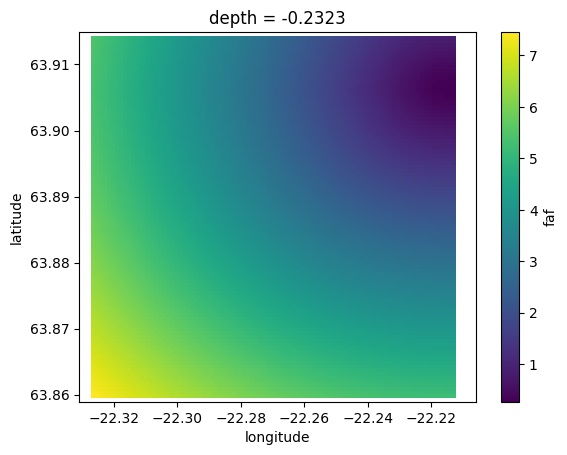

In [36]:
resampled['faf'].isel(depth = 25).plot(x = 'longitude')

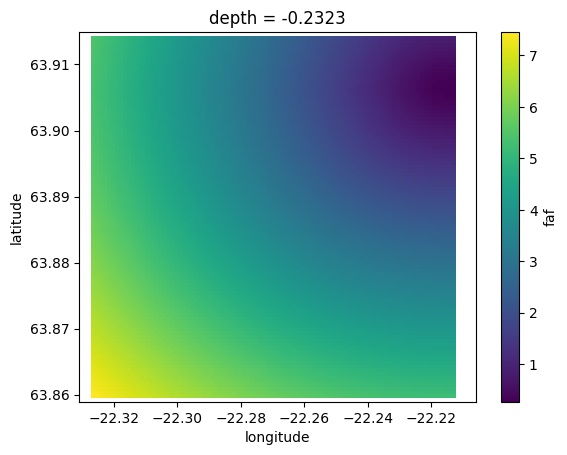

In [39]:
filled['faf'].isel(depth = 25).plot(x = 'longitude')

In [42]:
test = xr.load_dataset(r'C:\Users\liliv\Desktop\Fagradalfjall\Tremor_loc\Velocity model\ttime grids\fibre_AF.h5')

In [43]:
test

<xarray.Dataset>
Dimensions:    (depth: 102, longitude: 101, latitude: 100)
Coordinates:
  * depth      (depth) float64 5.0 4.931 4.861 4.792 ... -1.861 -1.931 -2.0
  * longitude  (longitude) float64 -22.33 -22.33 -22.33 ... -22.21 -22.21 -22.21
  * latitude   (latitude) float64 63.91 63.91 63.91 63.91 ... 63.86 63.86 63.86
Data variables:
    560        (latitude, longitude, depth) float64 7.666 7.62 ... 5.309 5.333
    1336       (latitude, longitude, depth) float64 7.841 7.796 ... 4.72 4.747
    1800       (latitude, longitude, depth) float64 7.977 7.933 ... 4.385 4.414
    2400       (latitude, longitude, depth) float64 8.191 8.148 ... 3.914 3.946
    3088       (latitude, longitude, depth) float64 8.27 8.227 ... 3.494 3.529
    3440       (latitude, longitude, depth) float64 8.106 8.062 ... 3.419 3.455
    3736       (latitude, longitude, depth) float64 7.96 7.915 ... 3.404 3.441
    4264       (latitude, longitude, depth) float64 7.838 7.792 ... 3.403 3.437